## Amazon Fine Food Review - Naive Bayes Algorithm

In [1]:
# Getting all the imports done

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

C:\Users\NamrataT\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# using SQLite Table to read data.
con = sqlite3.connect(r'C:\Users\NamrataT\Desktop\EXAM\PYTHON\Amazon Fine Food Reviews\database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
filtered_data['Score'].value_counts()

1    83876
0    16124
Name: Score, dtype: int64

In [4]:
'''demo_negative = filtered_data[filtered_data.Score == 0]
demo_positive = filtered_data[filtered_data.Score == 1]
demo_positive = demo_positive[0:50000]
demo_negative = demo_negative[0:60000]
print(demo_negative.shape,demo_positive.shape)'''

'demo_negative = filtered_data[filtered_data.Score == 0]\ndemo_positive = filtered_data[filtered_data.Score == 1]\ndemo_positive = demo_positive[0:50000]\ndemo_negative = demo_negative[0:60000]\nprint(demo_negative.shape,demo_positive.shape)'

In [5]:
'''filtered_data = pd.DataFrame(np.vstack((demo_positive,demo_negative)),columns=['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'])
print(filtered_data.shape)
print(type(filtered_data))'''

"filtered_data = pd.DataFrame(np.vstack((demo_positive,demo_negative)),columns=['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',\n       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'])\nprint(filtered_data.shape)\nprint(type(filtered_data))"

In [6]:
#Sorting data according to Time in ascending order
sorted_data=filtered_data.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
sorted_data.reset_index(drop=True, inplace=True)

In [7]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [8]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

In [9]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [10]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

In [11]:
final_score = final['Score']
final_score.shape

(87773,)

In [12]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [213]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below','not','no', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [214]:
# Combining all the above stundents 
from tqdm import tqdm
from bs4 import BeautifulSoup

preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 87773/87773 [01:17<00:00, 1135.36it/s]


In [215]:
# Processing the Summary column

preprocessed_summary = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 87773/87773 [00:37<00:00, 2372.20it/s]


In [216]:
preprocessed_summary[75000]

'best crushed tomatoes'

## 1) Applying Naive Bayes

## 1.1) Applying Naive Bayes on BOW, SET 1

In [16]:
# Getting all the imports done

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
#from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
#from sklearn import cross_validation
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc,roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from plotly.plotly import plotly as py
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from sklearn.utils import resample
from sklearn.naive_bayes import MultinomialNB
from scipy.sparse import hstack

In [217]:
final['Cleaned_Text']=preprocessed_reviews
final['Cleaned_Summary'] = preprocessed_summary
final['Word Count'] = final['Cleaned_Text'].apply(lambda x:len(x.split()))
final['Summary Word Count'] = final['Cleaned_Summary'].apply(lambda x:len(x.split()))
final.head()
word_count = final['Word Count']

In [218]:

final_review = final[['Cleaned_Text','Word Count','Summary Word Count','Score']]
X = final_review.drop(['Score'],axis=1)
Y = final_review['Score']

In [219]:
# Please write all the code with proper documentation
# TIME BASED SPILTTING
# SIMPLE CROSS VALIDATION

X_1, X_test, Y_1, Y_test = train_test_split(X,Y,test_size=0.2,shuffle = False)
X_1_train, X_1_cv, Y_1_train, Y_1_cv = train_test_split( X_1, Y_1, test_size=0.2,shuffle = False)
print(X_1_train.shape,Y_1_train.shape)

(56174, 3) (56174,)


In [220]:
df_post_split = pd.concat([X_1_train,Y_1_train],axis=1)
x_positive = df_post_split[df_post_split['Score']==1]
x_negetive = df_post_split[df_post_split['Score']==0]

In [221]:
df_post_split['Score'].value_counts()

1    47504
0     8670
Name: Score, dtype: int64

In [222]:
# Indicies of each class' observations
i_class0 = np.where(df_post_split['Score'] == 0)[0]
i_class1 = np.where(df_post_split['Score'] == 1)[0]

In [223]:
# For every observation of class 1, randomly sample from class 0 without replacement
#x_negetive_upsample = resample(x_negetive, replace = True, n_samples=17000)
x_negative_downsample = resample(x_negetive,replace=True,n_samples=30000,random_state=123) 

In [224]:
print(x_negative_downsample.shape, type(x_positive))

(30000, 4) <class 'pandas.core.frame.DataFrame'>


In [225]:
#df_upsample = pd.concat([x_positive,x_negetive_upsample])
df_upsample = pd.concat([x_positive,x_negative_downsample])
type(df_upsample)
df_upsample.head()

,Cleaned_Text,Word Count,Summary Word Count,Score
0,bought apartment infested fruit flies hours tr...,30,3,1
1,really good idea final product outstanding use...,17,2,1
2,received shipment could hardly wait try produc...,39,3,1
3,nothing product bother link top page buy used ...,16,5,1
4,love stuff sugar free rot gums tastes good goi...,12,4,1


In [226]:
df_upsample['Score'].value_counts()

1    47504
0    30000
Name: Score, dtype: int64

In [227]:
X_Train = df_upsample.drop(['Score'],axis=1)
Y_1_train = df_upsample['Score']
print(X_Train.shape, Y_1_train.shape)

(77504, 3) (77504,)


In [228]:
# BoW -- transform with unigram and bigram

ngram_vect = CountVectorizer(ngram_range=(1,2), min_df=10)
D1_Train = ngram_vect.fit_transform(X_Train['Cleaned_Text'])
D1_Cv = ngram_vect.transform(X_1_cv['Cleaned_Text'])
D1_Test = ngram_vect.transform(X_test['Cleaned_Text'])
print(D1_Train.shape,D1_Cv.shape,D1_Test.shape)

(77504, 51513) (14044, 51513) (17555, 51513)


In [229]:
X_Train_count  =  X_Train['Word Count'].values.reshape(-1,1)
X_Cv_count = X_1_cv['Word Count'].values.reshape(-1,1)
X_Test_count = X_test['Word Count'].values.reshape(-1,1)

X_Train_summary_count  =  X_Train['Summary Word Count'].values.reshape(-1,1)
X_Cv_summary_count = X_1_cv['Summary Word Count'].values.reshape(-1,1)
X_Test_summary_count = X_test['Summary Word Count'].values.reshape(-1,1)

In [230]:
#standardising word count feature
import warnings
warnings.filterwarnings('ignore')
word_scalar = StandardScaler()
word_scalar.fit(X_Train_count) 
X_Train_count = word_scalar.transform(X_Train_count)
X_Cv_count = word_scalar.transform(X_Cv_count)
X_Test_count = word_scalar.transform(X_Test_count)

summary_scalar = StandardScaler()
summary_scalar.fit(X_Train_summary_count) 
X_Train_summary_count = summary_scalar.transform(X_Train_summary_count)
X_Cv_summary_count = summary_scalar.transform(X_Cv_summary_count)
X_Test_summary_count = summary_scalar.transform(X_Test_summary_count)

In [231]:
D1_Train.shape

(77504, 51513)

In [232]:
D1_Train = hstack((D1_Train,X_Train_summary_count,X_Train_count))

In [233]:
D1_Cv = hstack((D1_Cv,X_Cv_summary_count,X_Cv_count))

In [234]:
D1_Test = hstack((D1_Test,X_Test_summary_count,X_Test_count))

In [235]:
print(D1_Train.shape)

(77504, 51515)


In [236]:
n_cv = D1_Cv.get_shape()[0]
n_train = D1_Train.get_shape()[0]
n_test = D1_Test.get_shape()[0]
print(n_train)
print(n_cv)
print(n_test)

77504
14044
17555


In [237]:
# Standardization Process
# Changes done as suggested

from sklearn.preprocessing import MaxAbsScaler
scaler = MaxAbsScaler()
scaler.fit(D1_Train)
D1_Train = scaler.transform(D1_Train)
D1_Cv = scaler.transform(D1_Cv)
D1_Test = scaler.transform(D1_Test)

print(D1_Train.shape)
print(D1_Cv.shape)
print(D1_Test.shape)

(77504, 51515)
(14044, 51515)
(17555, 51515)


In [238]:
D1_Train=D1_Train.astype('int')
D1_Cv=D1_Cv.astype('int')
D1_Test=D1_Test.astype('int')
Y_1_train=Y_1_train.astype('int')
Y_1_cv=Y_1_cv.astype('int')
Y_test=Y_test.astype('int')

In [239]:
# Applying Naive Bayes 

cv_score = []
train_score = []

# creating list of alpha for NB
neighbours = list((0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000))


cv_auc = []
train_auc = []
cv_score = []
train_score = []
for i in tqdm(neighbours):
    nb = MultinomialNB(alpha = i)
    
    predicted_labels_cv = []
    predicted_labels_train = []
    predict_cv_prob = []
    predict_train_prob = []
    accuracy_cv = []
    auc_score_cv = []
    auc_score_train = []
    accuracy_train = []
    
    # Fitting the model in Train - CrossValidation
    nb.fit(D1_Train,Y_1_train)
    
    # Predicting the model with CrossValidation and Train Data
    for j in range(0,n_cv,1000):
        predicted_labels_cv.extend(nb.predict(D1_Cv[j:j+1000]))
        predict_cv_prob.extend(nb.predict_log_proba(D1_Cv[j:j+1000])[:,1])
    
    for k in range(0,n_train,1000):
        predicted_labels_train.extend(nb.predict(D1_Train[k:k+1000]))
        predict_train_prob.extend(nb.predict_log_proba(D1_Train[k:k+1000])[:,1])
    
    print(len(predict_train_prob))
    print(len(Y_1_cv))
    
    # Getting the Cross-Validation Accuracy and AUC Score
    auc_score_cv = roc_auc_score(Y_1_cv,predict_cv_prob)
    accuracy_cv = accuracy_score(Y_1_cv,predicted_labels_cv,normalize=True)* float(100)
    print('\nCV Accuracy for Alpha = %f is %f%%' % (i,accuracy_cv))
    print('\nCV AUC for Alpha = %f is %f%%' % (i,auc_score_cv))
    cv_score.append(accuracy_cv)
    cv_auc.append(auc_score_cv)
    
    # Getting the Training Accuracy and AUC Score
    auc_score_train = roc_auc_score(Y_1_train,predict_train_prob)
    accuracy_train = accuracy_score(Y_1_train,predicted_labels_train, normalize=True)* float(100)
    print('\nTrain Accuracy for Alpha = %f is %f%%' % (i,accuracy_train))
    print('\nTrain AUC for Alpha = %f is %f%%' % (i,auc_score_train))
    train_score.append(accuracy_train)
    train_auc.append(auc_score_train)

# Misclassification Error ( Cross-Validation Error )
cv_error = [1 - x for x in cv_score]

# Misclassification Error ( Training Error )
train_error = [1 - x for x in train_score]  

print(cv_auc)
print(train_auc)

  0%|                                                                                           | 0/11 [00:00<?, ?it/s]

77504
14044

CV Accuracy for Alpha = 0.000010 is 85.531188%

CV AUC for Alpha = 0.000010 is 0.790185%

Train Accuracy for Alpha = 0.000010 is 94.009341%

Train AUC for Alpha = 0.000010 is 0.986390%


  9%|███████▌                                                                           | 1/11 [00:00<00:05,  1.79it/s]

77504
14044

CV Accuracy for Alpha = 0.000100 is 85.637995%

CV AUC for Alpha = 0.000100 is 0.796342%

Train Accuracy for Alpha = 0.000100 is 94.004180%

Train AUC for Alpha = 0.000100 is 0.986322%


 18%|███████████████                                                                    | 2/11 [00:01<00:05,  1.80it/s]

77504
14044

CV Accuracy for Alpha = 0.001000 is 85.801766%

CV AUC for Alpha = 0.001000 is 0.806238%

Train Accuracy for Alpha = 0.001000 is 93.974505%

Train AUC for Alpha = 0.001000 is 0.986131%


 27%|██████████████████████▋                                                            | 3/11 [00:01<00:04,  1.80it/s]

77504
14044

CV Accuracy for Alpha = 0.010000 is 86.029621%

CV AUC for Alpha = 0.010000 is 0.820648%

Train Accuracy for Alpha = 0.010000 is 93.925475%

Train AUC for Alpha = 0.010000 is 0.985687%


 36%|██████████████████████████████▏                                                    | 4/11 [00:02<00:03,  1.80it/s]

77504
14044

CV Accuracy for Alpha = 0.100000 is 86.442609%

CV AUC for Alpha = 0.100000 is 0.841055%

Train Accuracy for Alpha = 0.100000 is 93.784837%

Train AUC for Alpha = 0.100000 is 0.984468%


 45%|█████████████████████████████████████▋                                             | 5/11 [00:02<00:03,  1.82it/s]

77504
14044

CV Accuracy for Alpha = 1.000000 is 87.047850%

CV AUC for Alpha = 1.000000 is 0.863115%

Train Accuracy for Alpha = 1.000000 is 93.307442%

Train AUC for Alpha = 1.000000 is 0.981120%


 55%|█████████████████████████████████████████████▎                                     | 6/11 [00:03<00:02,  1.84it/s]

77504
14044

CV Accuracy for Alpha = 10.000000 is 87.681572%

CV AUC for Alpha = 10.000000 is 0.874486%

Train Accuracy for Alpha = 10.000000 is 91.844292%

Train AUC for Alpha = 10.000000 is 0.973183%


 64%|████████████████████████████████████████████████████▊                              | 7/11 [00:03<00:02,  1.84it/s]

77504
14044

CV Accuracy for Alpha = 100.000000 is 86.179151%

CV AUC for Alpha = 100.000000 is 0.864632%

Train Accuracy for Alpha = 100.000000 is 82.679604%

Train AUC for Alpha = 100.000000 is 0.954409%


 73%|████████████████████████████████████████████████████████████▎                      | 8/11 [00:04<00:01,  1.85it/s]

77504
14044

CV Accuracy for Alpha = 1000.000000 is 81.579322%

CV AUC for Alpha = 1000.000000 is 0.852487%

Train Accuracy for Alpha = 1000.000000 is 62.147760%

Train AUC for Alpha = 1000.000000 is 0.939832%


 82%|███████████████████████████████████████████████████████████████████▉               | 9/11 [00:04<00:01,  1.84it/s]

77504
14044

CV Accuracy for Alpha = 10000.000000 is 81.508117%

CV AUC for Alpha = 10000.000000 is 0.850316%

Train Accuracy for Alpha = 10000.000000 is 61.292320%

Train AUC for Alpha = 10000.000000 is 0.936926%


 91%|██████████████████████████████████████████████████████████████████████████▌       | 10/11 [00:05<00:00,  1.82it/s]

77504
14044

CV Accuracy for Alpha = 100000.000000 is 81.508117%

CV AUC for Alpha = 100000.000000 is 0.850099%

Train Accuracy for Alpha = 100000.000000 is 61.292320%

Train AUC for Alpha = 100000.000000 is 0.936608%


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:06<00:00,  1.80it/s]


[0.7901854452417848, 0.7963418085372377, 0.80623804761722, 0.820647881167628, 0.8410550857362449, 0.8631145956390603, 0.8744862521044654, 0.8646316406438823, 0.8524873587431911, 0.850315893922936, 0.8500989425440965]
[0.9863901573200853, 0.9863215637981363, 0.986131495242506, 0.9856867870775794, 0.9844682781099134, 0.9811204393314248, 0.9731827779415066, 0.9544088725861681, 0.9398319053834063, 0.9369256311749187, 0.9366081505417088]


In [240]:
import math
alpha = []
for n in range(len(neighbours)):
    alpha1 = neighbours[n]
    x = math.log(alpha1)
    print(alpha1,x)
    alpha.append(x)

1e-05 -11.512925464970229
0.0001 -9.210340371976182
0.001 -6.907755278982137
0.01 -4.605170185988091
0.1 -2.3025850929940455
1 0.0
10 2.302585092994046
100 4.605170185988092
1000 6.907755278982137
10000 9.210340371976184
100000 11.512925464970229


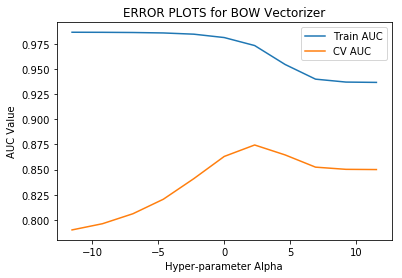

In [241]:
# Plotting Train_AUC and CV_AUC against K
plt.plot(alpha,train_auc)
plt.plot(alpha,cv_auc)
plt.legend(['Train AUC', 'CV AUC'], loc='upper right')
plt.title("ERROR PLOTS for BOW Vectorizer")
plt.xlabel('Hyper-parameter Alpha')
plt.ylabel('AUC Value')
plt.show()

In [242]:
# Getting the optimal Alpha Based to CV AUC
optimal_alpha_auc = neighbours[cv_auc.index(max(cv_auc))]
best_cv_auc = max([ '%.3f' % elem for elem in cv_auc ])
print('AUC Metric Best Alpha = %d' % optimal_alpha_auc)
print(best_cv_auc)

AUC Metric Best Alpha = 10
0.874


In [243]:
# Applying Best K on D_Test

test_neigh = MultinomialNB(alpha = optimal_alpha_auc)
test_neigh.fit(D1_Train,Y_1_train)

predicted_labels_test = []
predicted_labels_train = []
predict_test_prob = []
predict_train_prob = []
predict_test_logprob = []
predict_train_logprob = []

# Predicting the model with CrossValidation and Train Data
for j in range(0,n_test,1000):
    predicted_labels_test.extend(test_neigh.predict(D1_Test[j:j+1000]))
    predict_test_prob.extend(test_neigh.predict_proba(D1_Test[j:j+1000])[:,1])
    
for k in range(0,n_train,1000):
    predicted_labels_train.extend(test_neigh.predict(D1_Train[k:k+1000]))
    predict_train_prob.extend(test_neigh.predict_proba(D1_Train[k:k+1000])[:,1])
    
print(len(predict_test_prob))
print(len(Y_test))
    
train_fpr, train_tpr, thresholds = roc_curve(Y_1_train, predict_train_prob)
test_fpr, test_tpr, thresholds = roc_curve(Y_test, predict_test_prob)

print('Algo Run Successfully on D_Test')
print("="*100)


17555
17555
Algo Run Successfully on D_Test


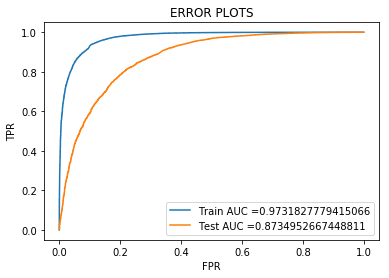

In [244]:
# Plotting the AUC curve on Test and Train Data

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

In [245]:
# Getting the confusion metrics

print('Train Confusion Matrix')
tr_true_negetive,tr_false_positive, tr_false_negetive, tr_true_positive = confusion_matrix(Y_1_train,predicted_labels_train).ravel()
print(tr_true_negetive, tr_false_positive, tr_false_negetive, tr_true_positive)
print(confusion_matrix(Y_1_train,predicted_labels_train))
print("="*120)

print('Test Confusion Matrix')
true_negetive,false_positive, false_negetive, true_positive = confusion_matrix(Y_test,predicted_labels_test).ravel()
print(true_negetive, false_positive, false_negetive, true_positive)
print(confusion_matrix(Y_test,predicted_labels_test))
print("="*120)

Train Confusion Matrix
25254 4746 1575 45929
[[25254  4746]
 [ 1575 45929]]
Test Confusion Matrix
1622 1292 684 13957
[[ 1622  1292]
 [  684 13957]]


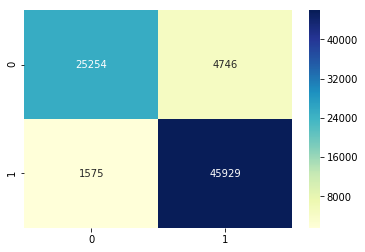

In [246]:
import seaborn as sns
conMatrix= [[tr_true_negetive,tr_false_positive],[tr_false_negetive,tr_true_positive]]
data = conMatrix
sns.heatmap(data, cmap="YlGnBu", annot=True, fmt="d")

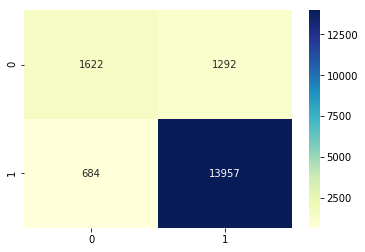

In [247]:
conMatrix= [[true_negetive,false_positive],[false_negetive,true_positive]]
data = conMatrix
sns.heatmap(data, cmap="YlGnBu", annot=True, fmt="d")

In [248]:
# Feature Importance :

neg_feature_prob = test_neigh.feature_log_prob_ [0,:]
pos_feature_prob = test_neigh.feature_log_prob_ [1,:]
indices_positive = np.argsort((test_neigh.feature_log_prob_)[1])[::-1][0:10]
indices_negetive = np.argsort((test_neigh.feature_log_prob_)[0])[::-1][0:10]
#indices_negetive = np.argsort(test_neigh.feature_log_prob_ [0,:])[-10:]
#indices_positive = np.argsort(test_neigh.feature_log_prob_ [1,:])[-10:]
print(indices_negetive,indices_positive)
feature_names = ngram_vect.get_feature_names()
print("="*110)

feature_name = []
prob = []

for i in indices_positive:
    feature_name.append(feature_names[i])
    prob.append(pos_feature_prob[i])

feature_df = pd.DataFrame(data = feature_name, columns = ['Positive Feature Name'])
prob_df = pd.DataFrame(data = prob, columns = ['Probability'])
pos_feature_prob_df = pd.concat([feature_df,prob_df],axis=1)

print(pos_feature_prob_df)
print("="*50, 'Positive',"="*50)

neg_feature_name = []
neg_prob = []

for i in indices_negetive:
    neg_feature_name.append(feature_names[i])
    neg_prob.append(neg_feature_prob[i])

neg_feature_df = pd.DataFrame(data = neg_feature_name, columns = ['Negative Feature Name'])
neg_prob_df = pd.DataFrame(data = neg_prob, columns = ['Probability'])
neg_feature_prob_df = pd.concat([neg_feature_df,neg_prob_df],axis=1)

print(neg_feature_prob_df)
print("="*50, 'Negetive', "="*50)

[50994 42045 21206 10049 51068 49334 36758 49241 50348  6234] [19892 15997 36981 17737 16144  1031 16083 16648 34607 18372]
  Positive Feature Name  Probability
0            good price    -7.635232
1           find amazon    -7.985578
2      recommend anyone    -8.027452
3          found amazon    -8.054120
4           find stores    -8.284894
5            also great    -8.359984
6            find local    -8.387893
7          flavor great    -8.402145
8           price great    -8.426360
9           full flavor    -8.431274
================================================== Positive ==================================================
  Negative Feature Name  Probability
0          would rather    -7.828436
1             stay away    -8.070350
2                hardly    -8.162158
3            could even    -8.242200
4             would try    -8.271801
5                wasted    -8.329212
6         really wanted    -8.394963
7           wanted like    -8.399829
8            wish could  

## 1.2) Applying Naive Bayes on TfIdf, SET 2

In [268]:
# Applying Tfidf for Vectorization
# fit_transform on D_Train
count_vect = TfidfVectorizer(ngram_range=(2,3),min_df=10) #in scikit-learn # changes done as suggested
D2_Train = count_vect.fit_transform(X_Train['Cleaned_Text'])
print(" some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

print("the type of count vectorizer ",type(D2_Train))
print("the shape of BOW vectorizer ",D2_Train.get_shape())
print("the number of unique words ", D2_Train.get_shape()[1])

 some feature names  ['able add', 'able buy', 'able chew', 'able drink', 'able eat', 'able enjoy', 'able feed', 'able figure', 'able find', 'able find amazon']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of BOW vectorizer  (77504, 46918)
the number of unique words  46918


In [269]:
# BoW -- transform on D_CV

D2_Cv = count_vect.transform(X_1_cv['Cleaned_Text'])
print("the type of count vectorizer ",type(D2_Cv))
print("the shape of BOW vectorizer ",D2_Cv.get_shape())
print("the number of unique words ", D2_Cv.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of BOW vectorizer  (14044, 46918)
the number of unique words  46918


In [270]:
# BoW -- transform on D_Test

D2_Test = count_vect.transform(X_test['Cleaned_Text'])
print("the type of count vectorizer ",type(D2_Test))
print("the shape of BOW vectorizer ",D2_Test.get_shape())
print("the number of unique words ", D2_Test.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of BOW vectorizer  (17555, 46918)
the number of unique words  46918


#### Without Feature Engineering we are getting a decent enough Confusion Matrix and AUC value. So commenting out the feature engineering code below.

In [91]:
'''D2_Train = hstack((D2_Train,X_Train_count))
D2_Cv = hstack((D2_Cv,X_Cv_count))
D2_Test = hstack((D2_Test,X_Test_count))'''

In [252]:
'''D2_Train = hstack((D2_Train,X_Train_summary_count,X_Train_count))
D2_Cv = hstack((D2_Cv,X_Cv_summary_count,X_Cv_count))
D2_Test = hstack((D2_Test,X_Test_summary_count,X_Test_count))'''

In [271]:

n_cv = D2_Cv.get_shape()[0]
n_train = D2_Train.get_shape()[0]
n_test = D2_Test.get_shape()[0]
print(n_train)
print(n_cv)
print(n_test)

77504
14044
17555


In [272]:
# Standardization Process
# Changes done as suggested

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=False)
scaler.fit(D2_Train)
D2_Train = scaler.transform(D2_Train)
D2_Cv = scaler.transform(D2_Cv)
D2_Test = scaler.transform(D2_Test)

print(D2_Train.shape)
print(D2_Cv.shape)
print(D2_Test.shape)

(77504, 46918)
(14044, 46918)
(17555, 46918)


In [1]:
# Standardization Process for Feature Engineering 
# Using MaxAbsScaler because otherwise we are getting negative values and Naive Bayes doesnt work with negative values.

'''from sklearn.preprocessing import MaxAbsScaler
scaler = MaxAbsScaler()
scaler.fit(D2_Train)
D2_Train = scaler.transform(D2_Train)
D2_Cv = scaler.transform(D2_Cv)
D2_Test = scaler.transform(D2_Test)

print(D2_Train.shape)
print(D2_Cv.shape)
print(D2_Test.shape)'''

'from sklearn.preprocessing import MaxAbsScaler\nscaler = MaxAbsScaler()\nscaler.fit(D2_Train)\nD2_Train = scaler.transform(D2_Train)\nD2_Cv = scaler.transform(D2_Cv)\nD2_Test = scaler.transform(D2_Test)\n\nprint(D2_Train.shape)\nprint(D2_Cv.shape)\nprint(D2_Test.shape)'

In [273]:
D2_Train=D2_Train.astype('int')
D2_Cv=D2_Cv.astype('int')
D2_Test=D2_Test.astype('int')
Y_1_train=Y_1_train.astype('int')
Y_1_cv=Y_1_cv.astype('int')
Y_test=Y_test.astype('int')

In [274]:
# Applying Naive Bayes 

cv_score = []
train_score = []

# creating odd list of alpha for NB
neighbours = list((0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000))


cv_auc = []
train_auc = []
cv_score = []
train_score = []
for i in tqdm(neighbours):
    nb = MultinomialNB(alpha = i)
    
    predicted_labels_cv = []
    predicted_labels_train = []
    predict_cv_prob = []
    predict_train_prob = []
    accuracy_cv = []
    auc_score_cv = []
    auc_score_train = []
    accuracy_train = []
    
    # Fitting the model in Train - CrossValidation
    nb.fit(D2_Train,Y_1_train)
    
    # Predicting the model with CrossValidation and Train Data
    for j in range(0,n_cv,1000):
        predicted_labels_cv.extend(nb.predict(D2_Cv[j:j+1000]))
        predict_cv_prob.extend(nb.predict_log_proba(D2_Cv[j:j+1000])[:,1])
    
    for k in range(0,n_train,1000):
        predicted_labels_train.extend(nb.predict(D2_Train[k:k+1000]))
        predict_train_prob.extend(nb.predict_log_proba(D2_Train[k:k+1000])[:,1])
    
    print(len(predict_cv_prob))
    print(len(Y_1_cv))
    
    # Getting the Cross-Validation Accuracy and AUC Score
    auc_score_cv = roc_auc_score(Y_1_cv,predict_cv_prob)
    accuracy_cv = accuracy_score(Y_1_cv,predicted_labels_cv,normalize=True)* float(100)
    print('\nCV Accuracy for Alpha = %f is %f%%' % (i,accuracy_cv))
    print('\nCV AUC for Alpha = %f is %f%%' % (i,auc_score_cv))
    cv_score.append(accuracy_cv)
    cv_auc.append(auc_score_cv)
    
    # Getting the Training Accuracy and AUC Score
    auc_score_train = roc_auc_score(Y_1_train,predict_train_prob)
    accuracy_train = accuracy_score(Y_1_train,predicted_labels_train, normalize=True)* float(100)
    print('\nTrain Accuracy for Alpha = %f is %f%%' % (i,accuracy_train))
    print('\nTrain AUC for Alpha = %f is %f%%' % (i,auc_score_train))
    train_score.append(accuracy_train)
    train_auc.append(auc_score_train)

# Misclassification Error ( Cross-Validation Error )
cv_error = [1 - x for x in cv_score]

# Misclassification Error ( Training Error )
train_error = [1 - x for x in train_score]  

print(cv_auc)
print(train_auc)

  0%|                                                                                           | 0/11 [00:00<?, ?it/s]

14044
14044

CV Accuracy for Alpha = 0.000010 is 85.367417%

CV AUC for Alpha = 0.000010 is 0.748273%

Train Accuracy for Alpha = 0.000010 is 95.398947%

Train AUC for Alpha = 0.000010 is 0.970369%


  9%|███████▌                                                                           | 1/11 [00:00<00:05,  1.74it/s]

14044
14044

CV Accuracy for Alpha = 0.000100 is 85.388778%

CV AUC for Alpha = 0.000100 is 0.748847%

Train Accuracy for Alpha = 0.000100 is 95.395076%

Train AUC for Alpha = 0.000100 is 0.970339%


 18%|███████████████                                                                    | 2/11 [00:01<00:05,  1.74it/s]

14044
14044

CV Accuracy for Alpha = 0.001000 is 85.452862%

CV AUC for Alpha = 0.001000 is 0.750098%

Train Accuracy for Alpha = 0.001000 is 95.391206%

Train AUC for Alpha = 0.001000 is 0.970267%


 27%|██████████████████████▋                                                            | 3/11 [00:01<00:04,  1.74it/s]

14044
14044

CV Accuracy for Alpha = 0.010000 is 85.573911%

CV AUC for Alpha = 0.010000 is 0.752910%

Train Accuracy for Alpha = 0.010000 is 95.364110%

Train AUC for Alpha = 0.010000 is 0.970129%


 36%|██████████████████████████████▏                                                    | 4/11 [00:02<00:03,  1.75it/s]

14044
14044

CV Accuracy for Alpha = 0.100000 is 85.702079%

CV AUC for Alpha = 0.100000 is 0.756841%

Train Accuracy for Alpha = 0.100000 is 95.338305%

Train AUC for Alpha = 0.100000 is 0.969915%


 45%|█████████████████████████████████████▋                                             | 5/11 [00:02<00:03,  1.77it/s]

14044
14044

CV Accuracy for Alpha = 1.000000 is 85.851609%

CV AUC for Alpha = 1.000000 is 0.761716%

Train Accuracy for Alpha = 1.000000 is 95.263470%

Train AUC for Alpha = 1.000000 is 0.969528%


 55%|█████████████████████████████████████████████▎                                     | 6/11 [00:03<00:02,  1.81it/s]

14044
14044

CV Accuracy for Alpha = 10.000000 is 86.008260%

CV AUC for Alpha = 10.000000 is 0.770166%

Train Accuracy for Alpha = 10.000000 is 95.130574%

Train AUC for Alpha = 10.000000 is 0.968712%


 64%|████████████████████████████████████████████████████▊                              | 7/11 [00:03<00:02,  1.84it/s]

14044
14044

CV Accuracy for Alpha = 100.000000 is 86.293079%

CV AUC for Alpha = 100.000000 is 0.783613%

Train Accuracy for Alpha = 100.000000 is 94.846718%

Train AUC for Alpha = 100.000000 is 0.967153%


 73%|████████████████████████████████████████████████████████████▎                      | 8/11 [00:04<00:01,  1.85it/s]

14044
14044

CV Accuracy for Alpha = 1000.000000 is 86.770151%

CV AUC for Alpha = 1000.000000 is 0.807548%

Train Accuracy for Alpha = 1000.000000 is 94.564152%

Train AUC for Alpha = 1000.000000 is 0.968484%


 82%|███████████████████████████████████████████████████████████████████▉               | 9/11 [00:04<00:01,  1.84it/s]

14044
14044

CV Accuracy for Alpha = 10000.000000 is 87.389633%

CV AUC for Alpha = 10000.000000 is 0.888322%

Train Accuracy for Alpha = 10000.000000 is 94.117723%

Train AUC for Alpha = 10000.000000 is 0.984415%


 91%|██████████████████████████████████████████████████████████████████████████▌       | 10/11 [00:05<00:00,  1.85it/s]

14044
14044

CV Accuracy for Alpha = 100000.000000 is 87.645970%

CV AUC for Alpha = 100000.000000 is 0.893347%

Train Accuracy for Alpha = 100000.000000 is 93.039069%

Train AUC for Alpha = 100000.000000 is 0.984281%


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:06<00:00,  1.88it/s]


[0.7482729920106255, 0.7488474027006116, 0.7500981318567207, 0.7529096696805512, 0.7568406288525521, 0.7617155510593615, 0.770165604593321, 0.7836133944257473, 0.8075483168834998, 0.888322482288415, 0.8933473480212619]
[0.9703687622796676, 0.9703385869260133, 0.9702667659565509, 0.9701287484562703, 0.9699153446727293, 0.9695279295778602, 0.9687122358117211, 0.967152816955765, 0.9684836020826316, 0.9844152780116762, 0.9842810854524531]


In [275]:
import math
alpha = []
for n in range(len(neighbours)):
    alpha1 = neighbours[n]
    x = int(math.log(alpha1))
    alpha.append(x)
    print(alpha)

[-11]
[-11, -9]
[-11, -9, -6]
[-11, -9, -6, -4]
[-11, -9, -6, -4, -2]
[-11, -9, -6, -4, -2, 0]
[-11, -9, -6, -4, -2, 0, 2]
[-11, -9, -6, -4, -2, 0, 2, 4]
[-11, -9, -6, -4, -2, 0, 2, 4, 6]
[-11, -9, -6, -4, -2, 0, 2, 4, 6, 9]
[-11, -9, -6, -4, -2, 0, 2, 4, 6, 9, 11]


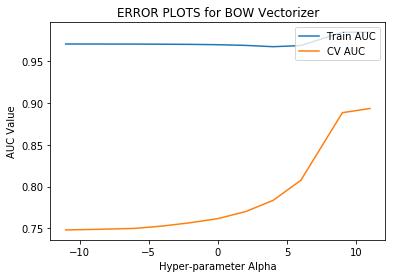

In [276]:
# Plotting Train_AUC and CV_AUC against K
plt.plot(alpha,train_auc)
plt.plot(alpha,cv_auc)
plt.legend(['Train AUC', 'CV AUC'], loc='upper right')
plt.title("ERROR PLOTS for BOW Vectorizer")
plt.xlabel('Hyper-parameter Alpha')
plt.ylabel('AUC Value')
plt.show()

In [277]:
# Getting the optimal Alpha Based to CV AUC
optimal_alpha_auc = neighbours[cv_auc.index(max(cv_auc))]
best_cv_auc = max([ '%.3f' % elem for elem in cv_auc ])
print('AUC Metric Best Alpha = %d' % optimal_alpha_auc)
print(best_cv_auc)

AUC Metric Best Alpha = 100000
0.893


In [290]:
# Applying Best K on D_Test

test_neigh = MultinomialNB(alpha = 1000)
test_neigh.fit(D2_Train,Y_1_train)

predicted_labels_test = []
predicted_labels_train = []
predict_test_prob = []
predict_train_prob = []

# Predicting the model with CrossValidation and Train Data
for j in range(0,n_test,1000):
    predicted_labels_test.extend(test_neigh.predict(D2_Test[j:j+1000]))
    predict_test_prob.extend(test_neigh.predict_proba(D2_Test[j:j+1000])[:,1])
    
for k in range(0,n_train,1000):
    predicted_labels_train.extend(test_neigh.predict(D2_Train[k:k+1000]))
    predict_train_prob.extend(test_neigh.predict_proba(D2_Train[k:k+1000])[:,1])
    
print(len(predict_test_prob))
print(len(Y_test))
    
train_fpr, train_tpr, thresholds = roc_curve(Y_1_train, predict_train_prob)
test_fpr, test_tpr, thresholds = roc_curve(Y_test, predict_test_prob)

print('Algo Run Successfully on D_Test')
print("="*100)


17555
17555
Algo Run Successfully on D_Test


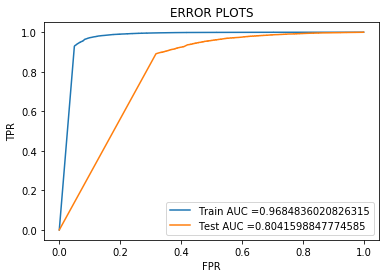

In [291]:
# Plotting the AUC curve on Test and Train Data

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

In [292]:
# Getting the confusion metrics

print('Train Confusion Matrix')
tr_true_negetive,tr_false_positive, tr_false_negetive, tr_true_positive = confusion_matrix(Y_1_train,predicted_labels_train).ravel()
print(tr_true_negetive, tr_false_positive, tr_false_negetive, tr_true_positive)
print(confusion_matrix(Y_1_train,predicted_labels_train))
print("="*120)

print('Test Confusion Matrix')
true_negetive,false_positive, false_negetive, true_positive = confusion_matrix(Y_test,predicted_labels_test).ravel()
print(true_negetive, false_positive, false_negetive, true_positive)
print(confusion_matrix(Y_test,predicted_labels_test))
print("="*120)

Train Confusion Matrix
27475 2525 1688 45816
[[27475  2525]
 [ 1688 45816]]
Test Confusion Matrix
1686 1228 931 13710
[[ 1686  1228]
 [  931 13710]]


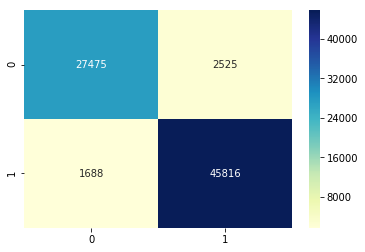

In [293]:
import seaborn as sns
conMatrix= [[tr_true_negetive,tr_false_positive],[tr_false_negetive,tr_true_positive]]
data = conMatrix
sns.heatmap(data, cmap="YlGnBu", annot=True, fmt="d")

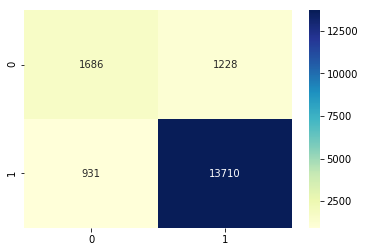

In [294]:
conMatrix= [[true_negetive,false_positive],[false_negetive,true_positive]]
data = conMatrix
sns.heatmap(data, cmap="YlGnBu", annot=True, fmt="d")

In [295]:
# Feature Importance :
neg_feature_prob = test_neigh.feature_log_prob_ [0,:]
pos_feature_prob = test_neigh.feature_log_prob_ [1,:]
indices_positive = np.argsort((test_neigh.feature_log_prob_)[1])[::-1][0:10]
indices_negetive = np.argsort((test_neigh.feature_log_prob_)[0])[::-1][0:10]
print(indices_negetive,indices_positive)
feature_names = count_vect.get_feature_names()

print("="*110)

feature_name = []
prob = []

for i in indices_positive:
    feature_name.append(feature_names[i])
    prob.append(pos_feature_prob[i])

feature_df = pd.DataFrame(data = feature_name, columns = ['Positive Feature Name'])
prob_df = pd.DataFrame(data = prob, columns = ['Probability'])
pos_feature_prob_df = pd.concat([feature_df,prob_df],axis=1)

print(pos_feature_prob_df)
print("="*50, 'Positive',"="*50)

neg_feature_name = []
neg_prob = []

for i in indices_negetive:
    neg_feature_name.append(feature_names[i])
    neg_prob.append(neg_feature_prob[i])

neg_feature_df = pd.DataFrame(data = neg_feature_name, columns = ['Negative Feature Name'])
neg_prob_df = pd.DataFrame(data = neg_prob, columns = ['Probability'])
neg_feature_prob_df = pd.concat([neg_feature_df,neg_prob_df],axis=1)

print(neg_feature_prob_df)
print("="*50, 'Negetive', "="*50)

[44668 39815 40240 40143 27223 41653  2541 27786 46392  9666] [19835 17398 18804 19043 33460 19367 40233 18796 33507 39757]
  Positive Feature Name  Probability
0      highly recommend    -8.951977
1           gluten free    -9.156279
2         great product    -9.185789
3         grocery store    -9.204261
4           really good    -9.210408
5             hard find    -9.253156
6          tastes great    -9.288267
7           great price    -9.305430
8           really like    -9.316600
9           taste great    -9.331295
================================================== Positive ==================================================
  Negative Feature Name  Probability
0           waste money    -9.145282
1            taste like    -9.227605
2           tastes like    -9.255280
3           tasted like    -9.344793
4             never buy    -9.361937
5         thought would    -9.376126
6             bad batch    -9.560919
7          nothing like    -9.575084
8          would rather  

## Conclusion for Brute Force

In [285]:
# Importing Pretty Table
from prettytable import PrettyTable

In [296]:
x = PrettyTable()
x.field_names = ['Vectorizer', 'Hyper-Parameter Value','AUC']
x.add_row(['BOW','Alpha = 10','0.87'])
x.add_row(['Tf-Idf','Alpha = 1000','0.80'])

print(x)

+------------+-----------------------+------+
| Vectorizer | Hyper-Parameter Value | AUC  |
+------------+-----------------------+------+
|    BOW     |       Alpha = 10      | 0.87 |
|   Tf-Idf   |      Alpha = 1000     | 0.80 |
+------------+-----------------------+------+


##### We have sampled top 100k datapoints that are highly imbalanced. We have thus balanced only the train datapoints with upsampling the negetive points. 

##### We are using MultinomialNB on Bag of Words and Tf-Idf Vectorizer. We have also done feature engineering by adding two new features that contains the word count of the reviews and word count of the summary text to see if the model performance is increasing or not. 

##### For Tf-Idf the model performance is getting very bad with feature engineering and we are getting a highly biased confusion matrix. So for Set 2, we have commented out the code for feature engineering and proceeded only with the features as got from Tf-Idf vectorizer.

##### For Bag of Words the model AUC and confusion matrix is getting better with feature engineering along with unigrams and bigrams implementaion of the CountVectorizer.

##### We have also performed a feature importance to check if the model is performing good. We have listed the top 10 features for each class along with their probabilities.